# Import libraries

In [1]:
# ! pip uninstall -y tensorflow
# ! pip install tensorflow==2.10.*

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from multiprocessing import Pool
from outer_function_daily import outer_function
from functools import partial
import numpy as np
from sklearn.metrics import r2_score
import csv

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Normalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [3]:
# Check if it detects GPU
tf.config.list_physical_devices('GPU') # need to use `! pip install tensorflow==2.10.*` to use gpu on windows 11 natively

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import Data

## Stock price data

In [4]:
# Import data
stocks_df = pd.read_csv("data/price.csv")

# Set date-time index
stocks_df['Date'] = pd.to_datetime(stocks_df["Date"], format='%Y-%m-%d')
stocks_df = stocks_df.set_index(stocks_df['Date'])
stocks_df = stocks_df.drop(columns = ["Date"])

# Drop all columns which only contain nan values
boolean = []
for stock in stocks_df.columns:
    boolean.append(not stocks_df[stock].isnull().all())
stocks_df = stocks_df.iloc[:, boolean]

stocks_df

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACHC,...,YUM,Z,ZBH,ZBRA,ZG,ZI,ZION,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,NaN,3.217068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,3.187954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,3.187954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,3.246180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,3.289852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,128.880005,26.809999,13.35,55.630001,189.429993,144.149994,133.699997,105.190002,81.989998,74.750000,...,125.650002,44.090000,116.889999,239.369995,42.330002,14.71,38.680000,68.160004,198.259995,182.119995
2023-12-05,127.879997,25.240000,13.13,53.160000,193.419998,144.570007,133.710007,104.349998,81.849998,74.209999,...,124.379997,44.290001,115.820000,234.360001,42.520000,14.48,37.389999,68.720001,198.910004,179.649994
2023-12-06,128.910004,25.120001,13.48,55.160000,192.320007,146.380005,135.309998,104.940002,79.970001,71.150002,...,124.809998,45.090000,116.129997,234.130005,43.490002,15.50,37.150002,70.940002,197.910004,182.000000


## Categorical variable data

In [5]:
# Read data
cat_variables = pd.read_csv("data/categorical.csv")
cat_variables = cat_variables.set_index("Unnamed: 0")
cat_variables = cat_variables.rename_axis(None, axis = 0)
cat_variables = cat_variables.dropna(axis="columns")

# Drop stocks such that the remaining stocks are those in both cat_variables and stocks_df
intersection = list(set(stocks_df.columns) & set(cat_variables.columns))
cat_variables = cat_variables[intersection]
stocks_df = stocks_df[intersection]

cat_variables

,JBLU,LII,CF,PPC,AA,EEFT,FTV,HRL,LULU,TOST,...,STLD,DVN,QRVO,FAST,EXP,NLY,PACW,APTV,ADP,UDR
sectors,Industrials,Industrials,Materials,Consumer Staples,Materials,Information Technology,Industrials,Consumer Staples,Consumer Discretionary,Information Technology,...,Materials,Energy,Information Technology,Industrials,Materials,Financials,Financials,Consumer Discretionary,Information Technology,Real Estate


In [6]:
# Get unique categories for each categorical variable
cats_df = pd.DataFrame()
for cat in cat_variables.index:
    uniques = list(cat_variables.loc[cat, :].unique())
    categories = np.sort(uniques)
    cats_df[cat] = categories

cats_df

,sectors
0,Communication Services
1,Consumer Discretionary
2,Consumer Staples
3,Energy
4,Financials
5,Health Care
6,Industrials
7,Information Technology
8,Information technology
9,Materials


## Numerical features data

In [7]:
# Read data
features_daily = pd.read_csv("data/features.csv")
features_daily['Date'] = pd.to_datetime(features_daily["Date"], format='%Y-%m-%d')
features_daily = features_daily.set_index("Date")
features_daily = features_daily.dropna()

# Make names smaller to use in file names
print(features_daily.columns)
features_daily.columns = ['BCI', 'CCI', 'CLI', '3m %', 'Broad $', 'Construction', 'Consumer prices', 'Manu $',
       'Indu production', 'Long %', 'MCI', 'Narrow $', 'Overnight %', 'Cars', 'producer $', 'Retail volume',
       'Total employment', 'Total manu']

features_daily

Index(['BCI', 'CCI', 'CLI', '3 month interbank rate', 'Broad money',
       'Construction', 'Consumer prices', 'Manufacturing hourly earnings',
       'Industrial production', 'Long-term interest rate',
       'Manufacturing confidence indicator', 'Narrow money',
       'Overnight interbank rate', 'Car registrations',
       'Manufacturing producer prices', 'Retail trade volume',
       'Total employment', 'Total manufacturing'],
      dtype='object')


,BCI,CCI,CLI,3m %,Broad $,Construction,Consumer prices,Manu $,Indu production,Long %,MCI,Narrow $,Overnight %,Cars,producer $,Retail volume,Total employment,Total manu
Date,,,,,,,,,,,,,,,,,,
1990-01-01,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-02,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-03,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-04,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-05,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796
2022-12-24,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796
2022-12-25,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796


# Training neural network on created data

In [8]:
# Convert to a numpy array for speedy opterations later on
stocks_np = stocks_df.to_numpy()

# Convert to a numpy array for speedy opterations later on
cat_variables_np = cat_variables.to_numpy()

# Convert to a numpy array for speedy opterations later on
features_daily_np = features_daily.to_numpy()

In [9]:
root_folder = "results"
overview_folder = "overview"
details_folder = "details"

# Create/load file to store results of each model
try:
    os.makedirs(f"{root_folder}/{overview_folder}")
except FileExistsError:
    pass


model_results_path = f"{root_folder}/{overview_folder}/model results.csv"
try:
    results = pd.read_csv(model_results_path)
except FileNotFoundError:
    # If the file does not exist then we create the file
    with open(model_results_path, "w") as f:
        f.write(",".join(["features","lines", "years", "layers", "neurons per layer", "total neurons", "batch size", "technique", "model name","val_loss", "val_r2"]) + "\n")
    results = pd.read_csv(model_results_path)

results

,features,lines,years,layers,neurons per layer,total neurons,batch size,technique,model name,val_loss,val_r2
0,[],20,2,2,32,64,1024,base,1,35.170811,0.900272
1,[sectors Cars Indu production Manu $],24,3,3,64,192,512,base,2,36.148407,0.897427
2,[BCI Broad $ CCI CLI Construction],28,2,4,128,512,1024,base,3,35.387295,0.897622
3,[sectors Consumer prices Retail volume Total e...,32,3,5,256,1280,512,base,4,35.674984,0.892163
4,[],36,2,2,16,32,2048,base,5,35.128540,0.900208
5,[sectors Cars Manu $ Narrow $],36,3,3,32,96,2048,base,6,35.450184,0.902452
6,[],44,2,2,16,32,2048,base,7,35.225101,0.899717
7,[sectors Cars Indu production Manu $ Narrow $],44,3,3,32,96,2048,base,8,35.322060,0.902732
8,[sectors Cars Indu production Manu $ Narrow $],44,3,3,32,96,2048,dropout layers,9,51.807827,0.790649
9,[],20,2,2,32,64,1024,dropout layers,10,41.194908,0.859676


## Training the models

In [10]:
def plot(history, model, x_test, y_train, y_test, features_string, batch_size, i, test_predictions, R2_score):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi=300)

    # PLot actual vs prediction scatter plot
    test_predictions = test_predictions.flatten()
    ax[0].scatter(y_test, test_predictions, alpha=0.01)
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predictions')

    # Plot y=x line
    # ax[0].axline((0, 0), slope=1, c='green', linewidth=2)
    points = [0, max(max(y_test), max(test_predictions))]
    ax[0].plot(points, points, color="green", linewidth = 3)
    ax[0].set_title("True values against predictions")
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    # Plot training and testing r-squared
    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label='val_loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Error')
    ax[1].set_title('loss')

    fig.suptitle(f"Val R2 = {R2_score}, Val loss={round(history.history['val_loss'][-1],3)}, BS={batch_size}, result index={i}, {features_string}", fontsize="small")

    plt.legend()
    plt.grid(True)
    return fig

In [11]:
# Constants
MAX_EPOCHS = 50
PATIENCE = 5

In [12]:
def create_model(NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER,layer,neuron,BATCH_SIZE,technique,cats_subset,features_subset, results = results):
    # Sort for consistency in file names and such
    cats_subset.sort()
    features_subset.sort()

    # Indexes of features columns in df to be used to find corresponding columns in numpy
    def get_feature_index(feature):
        return list(features_daily.columns).index(feature)
    def get_cat_index(cat):
        return list(cat_variables.index).index(cat)

    cats_subset_indexes = []
    for var in cats_subset:
        cats_subset_indexes.append(get_cat_index(var))

    features_subset_indexes = []
    for var in features_subset:
        features_subset_indexes.append(get_feature_index(var))



    p = Pool(os.cpu_count())
    first_index = NUMBER_OF_YEARS_TO_CONSIDER*365+1 # `+1` needed since slicing is end-exclusive
    range_iterations = range(first_index, len(stocks_np) - 365)

    iterations = tqdm(range_iterations,
                        desc=f"Working on Dataset: {NUMBER_OF_LINES} lines, {NUMBER_OF_YEARS_TO_CONSIDER} years",
                        disable=False)

    result_list = p.map(partial(outer_function,
                                stocks_np = stocks_np,
                                NUMBER_OF_YEARS_TO_CONSIDER = NUMBER_OF_YEARS_TO_CONSIDER,
                                NUMBER_OF_LINES = NUMBER_OF_LINES,
                                features_subset_indexes = features_subset_indexes,
                                features_np = features_daily_np,
                                cats_np = cat_variables_np,
                                cats_index = cats_subset_indexes,
                                cats_df = cats_df,
                                dates = np.array(stocks_df.index),
                                stocks = np.array(stocks_df.columns)
                                ),
                        iterations)

    data = np.vstack([result[0] for result in result_list])
    data_dates = np.hstack([result[1] for result in result_list])
    data_stocks = np.hstack([result[2] for result in result_list])

    cats_dict = dict()
    for k in cats_subset_indexes:
        cats_dict[k] = np.hstack([result_list[i][3][k] for i in range(len(result_list))])

    features_dict = dict()
    for k in features_subset_indexes:
        features_dict[k] = np.vstack([result_list[i][4][k] for i in range(len(result_list))])

    # To ensure we don't run into a memory error
    del result_list

    # Create folders
    models_path = f'{root_folder}/{details_folder}/models'
    graphs_path = f'{root_folder}/{details_folder}/training & validation details'
    try:
        os.makedirs(graphs_path)
    except FileExistsError:
        pass
    
    try:
        os.makedirs(models_path)
    except FileExistsError:
        pass

    # Get name of next model
    files = os.listdir(models_path)
    numbers = sorted([file_name[0] for file_name in files])
    try:
        model_name =  str(int(numbers[-1]) + 1)
    except IndexError:
        model_name = "1"

    # Creating neural networks
    features_string = f"{cats_subset + features_subset}".replace("'","").replace(",","")

    categorical_dummy_dfs_list = []
    for c in cats_subset_indexes:
        categorical_dummy_dfs_list.append(pd.get_dummies(cats_dict[c]).iloc[:,:-1])


    # The `data` list must go last since the rest of the script expects the dependent variable to be the last column !!
    model_data = np.hstack(categorical_dummy_dfs_list + [features_dict[f] for f in features_subset_indexes] + [data])
    del cats_dict, categorical_dummy_dfs_list, features_dict, data


    # Create data for model
    tuples = list(zip(data_dates, data_stocks))
    index = pd.MultiIndex.from_tuples(tuples, names=["dates", "stocks"])
    model_data = pd.DataFrame(model_data, index=index)

    # Split the data into 60% train and 40% for the combined test and validation sets (the test data won't be used in this notebook.)
    x_train, x_temp, y_train, y_temp = train_test_split(model_data.iloc[:,:-1], model_data.iloc[:,-1], test_size=0.4, random_state=42, shuffle=False)

    # Split the temp data into test and validation sets (50% each of the temp data)
    x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

    # # Normalize the data
    # normalizer = preprocessing.Normalization(axis=-1)
    # normalizer.adapt(x_train)

    model = Sequential()
    # model.add(normalizer)
    if technique == "dropout & batch":
        for _ in range(layer):
            model.add(Dense(neuron))
            model.add(BatchNormalization(axis=1))
            model.add(Activation("relu"))
            model.add(Dropout(0.5))
    else:
        for _ in range(layer):
            model.add(Dense(neuron))
            if technique == "batch regularisation":
                model.add(BatchNormalization(axis=1))

            model.add(Activation("relu"))

            if technique == "dropout layers":
                model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(loss='mean_absolute_error',
                    optimizer= Adam(learning_rate=0.00001),
                    metrics=[RSquare()])

    checkpoint_cb = ModelCheckpoint(f"{models_path}/{model_name}.h5",
                                    monitor='val_loss',
                                    save_best_only=True,
                                    verbose=0,
                                    save_weights_only=False,
                                    mode = "min")
    early_stopping_cb = EarlyStopping(monitor = "val_loss",
                                        patience = PATIENCE, # No. epochs with no improvement after which training is stopped.
                                        restore_best_weights=True,
                                        verbose = 0,
                                        min_delta = 0.01, 
                                        mode = "min")


    # tensorboard_callback = tf.keras.callbacks.TensorBoard(f"{root_folder}/{details_folder}/{technique}/logs/{data_name}/{model_name}")

    # reducelr_cb = ReduceLROnPlateau(monitor='val_r_square',
    #                                 factor=0.5,
    #                                 patience=REDUCE_LR_PATIENCE,
    #                                 verbose = 0,
    #                                 mode = "max")

    history = model.fit(
        x_train, y_train,
        validation_data = (x_val, y_val),
        verbose=1,
        epochs=MAX_EPOCHS,
        callbacks=[checkpoint_cb, early_stopping_cb], # , tensorboard_callback , reducelr_cb
        batch_size = BATCH_SIZE)

    model = tf.keras.models.load_model(f"{models_path}/{model_name}.h5")

    # Calculate r-squared
    test_predictions = model.predict(x_val, batch_size=BATCH_SIZE)
    plt.close("all")
    index = len(results)
    val_loss = min(history.history["val_loss"])
    R2_score = r2_score(y_val, test_predictions)
    fig = plot(history, model, x_val, y_train, y_val, features_string, BATCH_SIZE, index, test_predictions, R2_score)
    
    plt.savefig(
        f'{graphs_path}/{model_name}.png',
        bbox_inches='tight',
        dpi = 300
    )


    # Add result to `results` dataframe and to "model results.csv"
    total_neurons = layer * neuron
    result_row = [features_string, NUMBER_OF_LINES, NUMBER_OF_YEARS_TO_CONSIDER, layer, neuron, total_neurons, BATCH_SIZE, technique, model_name, val_loss, R2_score]
    new_row = pd.DataFrame([{"features": features_string,
                            "lines": NUMBER_OF_LINES,
                            "years": NUMBER_OF_YEARS_TO_CONSIDER,
                            "layers": layer,
                            "neurons per layer": neuron,
                            "total neurons": total_neurons,
                            "batch size": BATCH_SIZE,
                            "technique": technique,
                            "model name": model_name,
                            "val_loss": val_loss,
                            "val_r2": R2_score}])
    results = pd.concat([results, new_row], ignore_index=True)

    with open(f"{root_folder}/{overview_folder}/model results.csv", "a") as f:
        writer = csv.writer(f)
        writer.writerow(result_row)


    p.close()
    p.join()

In [13]:
# Dictionary of arguments and their values
arguments = {
    'NUMBER_OF_LINES': [42, 36, 30, 24, 34, 44, 46, 28, 38, 32, 40, 20],
    'NUMBER_OF_YEARS_TO_CONSIDER': [3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2],
    'layer': [4, 2, 5, 4, 4, 2, 5, 2, 5, 3, 3, 3],
    'neuron': [128, 64, 256, 128, 128, 64, 256, 64, 256, 32, 32, 32],
    'BATCH_SIZE': [2048, 2048, 512, 1024, 512, 1024, 512, 2048, 1024, 1024, 512, 2048],
    'technique': ['base', 'batch normalization', 'dropout & batch', 'base', 'base', 'batch normalization', 'dropout & batch', 'batch normalization', 'dropout & batch', 'dropout layers', 'dropout layers', 'base'],
    'cats_subset': [[], [], [], [], [], [], [], [], [], [], [], []],
    'features_subset': [[], [], [], [], [], [], [], [], [], [], [], []]
}


args_df = pd.DataFrame.from_dict(arguments, orient='index').transpose()
args_df

,NUMBER_OF_LINES,NUMBER_OF_YEARS_TO_CONSIDER,layer,neuron,BATCH_SIZE,technique,cats_subset,features_subset
0,42,3,4,128,2048,base,[],[]
1,36,2,2,64,2048,batch normalization,[],[]
2,30,3,5,256,512,dropout & batch,[],[]
3,24,3,4,128,1024,base,[],[]
4,34,3,4,128,512,base,[],[]
5,44,2,2,64,1024,batch normalization,[],[]
6,46,3,5,256,512,dropout & batch,[],[]
7,28,2,2,64,2048,batch normalization,[],[]
8,38,3,5,256,1024,dropout & batch,[],[]
9,32,2,3,32,1024,dropout layers,[],[]


Working on Dataset: 42 lines, 3 years:   0%|          | 0/9618 [00:00<?, ?it/s]

Epoch 1/50
1484/1484 [==============================] - 8s 4ms/step - loss: 12.0910 - r_square: 0.4989 - val_loss: 35.3199 - val_r_square: 0.9035
Epoch 2/50
1484/1484 [==============================] - 5s 4ms/step - loss: 6.2791 - r_square: 0.8269 - val_loss: 35.3037 - val_r_square: 0.9035
Epoch 3/50
1484/1484 [==============================] - 5s 4ms/step - loss: 6.2650 - r_square: 0.8274 - val_loss: 35.3062 - val_r_square: 0.9035
Epoch 4/50
1484/1484 [==============================] - 5s 4ms/step - loss: 6.2464 - r_square: 0.8283 - val_loss: 35.3171 - val_r_square: 0.9034
Epoch 5/50
1484/1484 [==============================] - 5s 4ms/step - loss: 6.2293 - r_square: 0.8289 - val_loss: 35.4231 - val_r_square: 0.9025
Epoch 6/50
1484/1484 [==============================] - 5s 4ms/step - loss: 6.2185 - r_square: 0.8293 - val_loss: 35.3787 - val_r_square: 0.9026
Epoch 7/50
495/495 [==============================] - 1s 1ms/step


Working on Dataset: 36 lines, 2 years:   0%|          | 0/9983 [00:00<?, ?it/s]

Epoch 1/50
1579/1579 [==============================] - 8s 4ms/step - loss: 13.8636 - r_square: 0.4001 - val_loss: 56.3933 - val_r_square: 0.7445
Epoch 2/50
1579/1579 [==============================] - 6s 4ms/step - loss: 6.8493 - r_square: 0.7901 - val_loss: 35.3076 - val_r_square: 0.8996
Epoch 3/50
1579/1579 [==============================] - 5s 3ms/step - loss: 6.0705 - r_square: 0.8096 - val_loss: 35.1134 - val_r_square: 0.9007
Epoch 4/50
1579/1579 [==============================] - 5s 3ms/step - loss: 6.0620 - r_square: 0.8095 - val_loss: 35.1214 - val_r_square: 0.9006
Epoch 5/50
1579/1579 [==============================] - 5s 3ms/step - loss: 6.0546 - r_square: 0.8101 - val_loss: 35.1313 - val_r_square: 0.9005
Epoch 6/50
1579/1579 [==============================] - 5s 3ms/step - loss: 6.0474 - r_square: 0.8107 - val_loss: 35.1563 - val_r_square: 0.9003
Epoch 7/50
1579/1579 [==============================] - 5s 3ms/step - loss: 6.0398 - r_square: 0.8112 - val_loss: 35.1413 - val_r

Working on Dataset: 30 lines, 3 years:   0%|          | 0/9618 [00:00<?, ?it/s]

Epoch 1/50
5936/5936 [==============================] - 47s 8ms/step - loss: 17.5876 - r_square: -0.0486 - val_loss: 117.5972 - val_r_square: -0.1987
Epoch 2/50
5936/5936 [==============================] - 47s 8ms/step - loss: 11.1706 - r_square: 0.1471 - val_loss: 87.7477 - val_r_square: 0.2313
Epoch 3/50
5936/5936 [==============================] - 47s 8ms/step - loss: 8.6829 - r_square: 0.4257 - val_loss: 71.2080 - val_r_square: 0.5343
Epoch 4/50
5936/5936 [==============================] - 48s 8ms/step - loss: 8.1295 - r_square: 0.5597 - val_loss: 64.3745 - val_r_square: 0.6604
Epoch 5/50
5936/5936 [==============================] - 47s 8ms/step - loss: 7.9677 - r_square: 0.5998 - val_loss: 61.1383 - val_r_square: 0.7132
Epoch 6/50
5936/5936 [==============================] - 44s 7ms/step - loss: 7.8904 - r_square: 0.6183 - val_loss: 61.0239 - val_r_square: 0.7214
Epoch 7/50
5936/5936 [==============================] - 44s 7ms/step - loss: 7.8525 - r_square: 0.6260 - val_loss: 66.9

Working on Dataset: 24 lines, 3 years:   0%|          | 0/9618 [00:00<?, ?it/s]

Epoch 1/50
2968/2968 [==============================] - 10s 3ms/step - loss: 8.7477 - r_square: 0.6908 - val_loss: 35.2975 - val_r_square: 0.9035
Epoch 2/50
2968/2968 [==============================] - 10s 3ms/step - loss: 6.2576 - r_square: 0.8278 - val_loss: 35.2760 - val_r_square: 0.9036
Epoch 3/50
2968/2968 [==============================] - 10s 3ms/step - loss: 6.2306 - r_square: 0.8291 - val_loss: 35.3686 - val_r_square: 0.9027
Epoch 4/50
2968/2968 [==============================] - 10s 4ms/step - loss: 6.2181 - r_square: 0.8297 - val_loss: 35.5603 - val_r_square: 0.9011
Epoch 5/50
2968/2968 [==============================] - 10s 3ms/step - loss: 6.2129 - r_square: 0.8299 - val_loss: 35.8116 - val_r_square: 0.8992
Epoch 6/50
2968/2968 [==============================] - 10s 3ms/step - loss: 6.2090 - r_square: 0.8300 - val_loss: 35.5069 - val_r_square: 0.9013
Epoch 7/50
990/990 [==============================] - 1s 955us/step


Working on Dataset: 34 lines, 3 years:   0%|          | 0/9618 [00:00<?, ?it/s]

Epoch 1/50
5936/5936 [==============================] - 21s 3ms/step - loss: 7.2699 - r_square: 0.7722 - val_loss: 35.2712 - val_r_square: 0.9036
Epoch 2/50
5936/5936 [==============================] - 20s 3ms/step - loss: 6.2280 - r_square: 0.8292 - val_loss: 35.5152 - val_r_square: 0.9015
Epoch 3/50
5936/5936 [==============================] - 21s 4ms/step - loss: 6.2126 - r_square: 0.8297 - val_loss: 35.5194 - val_r_square: 0.9012
Epoch 4/50
5936/5936 [==============================] - 22s 4ms/step - loss: 6.2058 - r_square: 0.8300 - val_loss: 35.5290 - val_r_square: 0.9009
Epoch 5/50
5936/5936 [==============================] - 20s 3ms/step - loss: 6.1998 - r_square: 0.8301 - val_loss: 35.5912 - val_r_square: 0.9004
Epoch 6/50
1979/1979 [==============================] - 2s 884us/step


Working on Dataset: 44 lines, 2 years:   0%|          | 0/9983 [00:00<?, ?it/s]

Epoch 1/50
3157/3157 [==============================] - 11s 3ms/step - loss: 11.6524 - r_square: 0.5260 - val_loss: 37.1863 - val_r_square: 0.8872
Epoch 2/50
3157/3157 [==============================] - 9s 3ms/step - loss: 6.0801 - r_square: 0.8106 - val_loss: 35.1713 - val_r_square: 0.9002
Epoch 3/50
3157/3157 [==============================] - 9s 3ms/step - loss: 6.0558 - r_square: 0.8104 - val_loss: 35.1478 - val_r_square: 0.9003
Epoch 4/50
3157/3157 [==============================] - 9s 3ms/step - loss: 6.0490 - r_square: 0.8108 - val_loss: 35.1227 - val_r_square: 0.9004
Epoch 5/50
3157/3157 [==============================] - 9s 3ms/step - loss: 6.0416 - r_square: 0.8111 - val_loss: 35.1790 - val_r_square: 0.9000
Epoch 6/50
3157/3157 [==============================] - 10s 3ms/step - loss: 6.0323 - r_square: 0.8116 - val_loss: 35.1527 - val_r_square: 0.9000
Epoch 7/50
3157/3157 [==============================] - 10s 3ms/step - loss: 6.0215 - r_square: 0.8120 - val_loss: 35.1759 - va

Working on Dataset: 46 lines, 3 years:   0%|          | 0/9618 [00:00<?, ?it/s]

Epoch 1/50
5936/5936 [==============================] - 46s 7ms/step - loss: 18.1047 - r_square: -0.0428 - val_loss: 120.1989 - val_r_square: -0.2116
Epoch 2/50
5936/5936 [==============================] - 45s 8ms/step - loss: 11.5597 - r_square: 0.1391 - val_loss: 91.3863 - val_r_square: 0.1718
Epoch 3/50
5936/5936 [==============================] - 43s 7ms/step - loss: 8.7888 - r_square: 0.4059 - val_loss: 73.1857 - val_r_square: 0.5096
Epoch 4/50
5936/5936 [==============================] - 44s 7ms/step - loss: 8.1429 - r_square: 0.5523 - val_loss: 66.6774 - val_r_square: 0.6334
Epoch 5/50
5936/5936 [==============================] - 46s 8ms/step - loss: 7.9827 - r_square: 0.5957 - val_loss: 63.4311 - val_r_square: 0.6920
Epoch 6/50
5936/5936 [==============================] - 46s 8ms/step - loss: 7.9090 - r_square: 0.6150 - val_loss: 60.3385 - val_r_square: 0.7361
Epoch 7/50
5936/5936 [==============================] - 43s 7ms/step - loss: 7.8658 - r_square: 0.6193 - val_loss: 63.1

Working on Dataset: 28 lines, 2 years:   0%|          | 0/9983 [00:00<?, ?it/s]

Epoch 1/50
1579/1579 [==============================] - 16s 9ms/step - loss: 13.4555 - r_square: 0.4353 - val_loss: 56.6639 - val_r_square: 0.7422
Epoch 2/50
1579/1579 [==============================] - 6s 4ms/step - loss: 6.8707 - r_square: 0.7904 - val_loss: 35.3059 - val_r_square: 0.8996
Epoch 3/50
1579/1579 [==============================] - 6s 4ms/step - loss: 6.0722 - r_square: 0.8096 - val_loss: 35.1285 - val_r_square: 0.9006
Epoch 4/50
1579/1579 [==============================] - 7s 4ms/step - loss: 6.0649 - r_square: 0.8097 - val_loss: 35.1238 - val_r_square: 0.9006
Epoch 5/50
1579/1579 [==============================] - 8s 5ms/step - loss: 6.0602 - r_square: 0.8102 - val_loss: 35.1080 - val_r_square: 0.9007
Epoch 6/50
1579/1579 [==============================] - 8s 5ms/step - loss: 6.0565 - r_square: 0.8105 - val_loss: 35.1260 - val_r_square: 0.9005
Epoch 7/50
1579/1579 [==============================] - 8s 5ms/step - loss: 6.0530 - r_square: 0.8108 - val_loss: 35.1190 - val_

Working on Dataset: 38 lines, 3 years:   0%|          | 0/9618 [00:00<?, ?it/s]

Epoch 1/50
2968/2968 [==============================] - 29s 9ms/step - loss: 20.4147 - r_square: -0.1073 - val_loss: 130.6297 - val_r_square: -0.2607
Epoch 2/50
2968/2968 [==============================] - 26s 9ms/step - loss: 16.2832 - r_square: -0.0425 - val_loss: 120.2228 - val_r_square: -0.2285
Epoch 3/50
2968/2968 [==============================] - 26s 9ms/step - loss: 12.7372 - r_square: 0.0440 - val_loss: 103.7074 - val_r_square: -0.0520
Epoch 4/50
2968/2968 [==============================] - 26s 9ms/step - loss: 10.3982 - r_square: 0.1747 - val_loss: 88.2920 - val_r_square: 0.1793
Epoch 5/50
2968/2968 [==============================] - 26s 9ms/step - loss: 9.0555 - r_square: 0.3534 - val_loss: 72.0378 - val_r_square: 0.4659
Epoch 6/50
2968/2968 [==============================] - 27s 9ms/step - loss: 8.2698 - r_square: 0.5145 - val_loss: 63.0503 - val_r_square: 0.6196
Epoch 7/50
2968/2968 [==============================] - 26s 9ms/step - loss: 7.8728 - r_square: 0.6085 - val_los

Working on Dataset: 32 lines, 2 years:   0%|          | 0/9983 [00:00<?, ?it/s]

Epoch 1/50
3157/3157 [==============================] - 29s 5ms/step - loss: 15.0433 - r_square: 0.2419 - val_loss: 55.9464 - val_r_square: 0.7475
Epoch 2/50
3157/3157 [==============================] - 11s 4ms/step - loss: 10.6673 - r_square: 0.5341 - val_loss: 47.2472 - val_r_square: 0.8167
Epoch 3/50
3157/3157 [==============================] - 13s 4ms/step - loss: 9.9431 - r_square: 0.5859 - val_loss: 49.4206 - val_r_square: 0.7994
Epoch 4/50
3157/3157 [==============================] - 13s 4ms/step - loss: 9.4864 - r_square: 0.6186 - val_loss: 51.8718 - val_r_square: 0.7792
Epoch 5/50
3157/3157 [==============================] - 14s 5ms/step - loss: 9.2034 - r_square: 0.6349 - val_loss: 53.1403 - val_r_square: 0.7683
Epoch 6/50
3157/3157 [==============================] - 14s 5ms/step - loss: 9.0193 - r_square: 0.6463 - val_loss: 54.2431 - val_r_square: 0.7585
Epoch 7/50
1053/1053 [==============================] - 1s 1ms/step


Working on Dataset: 40 lines, 2 years:   0%|          | 0/9983 [00:00<?, ?it/s]

Epoch 1/50
6313/6313 [==============================] - 24s 4ms/step - loss: 13.5627 - r_square: 0.3525 - val_loss: 48.9340 - val_r_square: 0.8035
Epoch 2/50
6313/6313 [==============================] - 21s 3ms/step - loss: 9.7894 - r_square: 0.6049 - val_loss: 51.4751 - val_r_square: 0.7824
Epoch 3/50
6313/6313 [==============================] - 22s 4ms/step - loss: 9.1759 - r_square: 0.6410 - val_loss: 53.2897 - val_r_square: 0.7670
Epoch 4/50
6313/6313 [==============================] - 24s 4ms/step - loss: 8.8678 - r_square: 0.6645 - val_loss: 54.6999 - val_r_square: 0.7548
Epoch 5/50
6313/6313 [==============================] - 24s 4ms/step - loss: 8.7094 - r_square: 0.6643 - val_loss: 56.4092 - val_r_square: 0.7395
Epoch 6/50
2105/2105 [==============================] - 2s 874us/step


Working on Dataset: 20 lines, 2 years:   0%|          | 0/9983 [00:00<?, ?it/s]

Epoch 1/50
1579/1579 [==============================] - 9s 6ms/step - loss: 13.9199 - r_square: 0.4116 - val_loss: 71.5779 - val_r_square: 0.5989
Epoch 2/50
1579/1579 [==============================] - 8s 5ms/step - loss: 8.3301 - r_square: 0.7308 - val_loss: 38.5167 - val_r_square: 0.8786
Epoch 3/50
1579/1579 [==============================] - 8s 5ms/step - loss: 6.1303 - r_square: 0.8113 - val_loss: 35.1707 - val_r_square: 0.9003
Epoch 4/50
1579/1579 [==============================] - 8s 5ms/step - loss: 6.0594 - r_square: 0.8106 - val_loss: 35.1436 - val_r_square: 0.9004
Epoch 5/50
1579/1579 [==============================] - 8s 5ms/step - loss: 6.0558 - r_square: 0.8107 - val_loss: 35.1553 - val_r_square: 0.9003
Epoch 6/50
1579/1579 [==============================] - 8s 5ms/step - loss: 6.0512 - r_square: 0.8110 - val_loss: 35.1840 - val_r_square: 0.9001
Epoch 7/50
1579/1579 [==============================] - 8s 5ms/step - loss: 6.0446 - r_square: 0.8114 - val_loss: 35.1706 - val_r

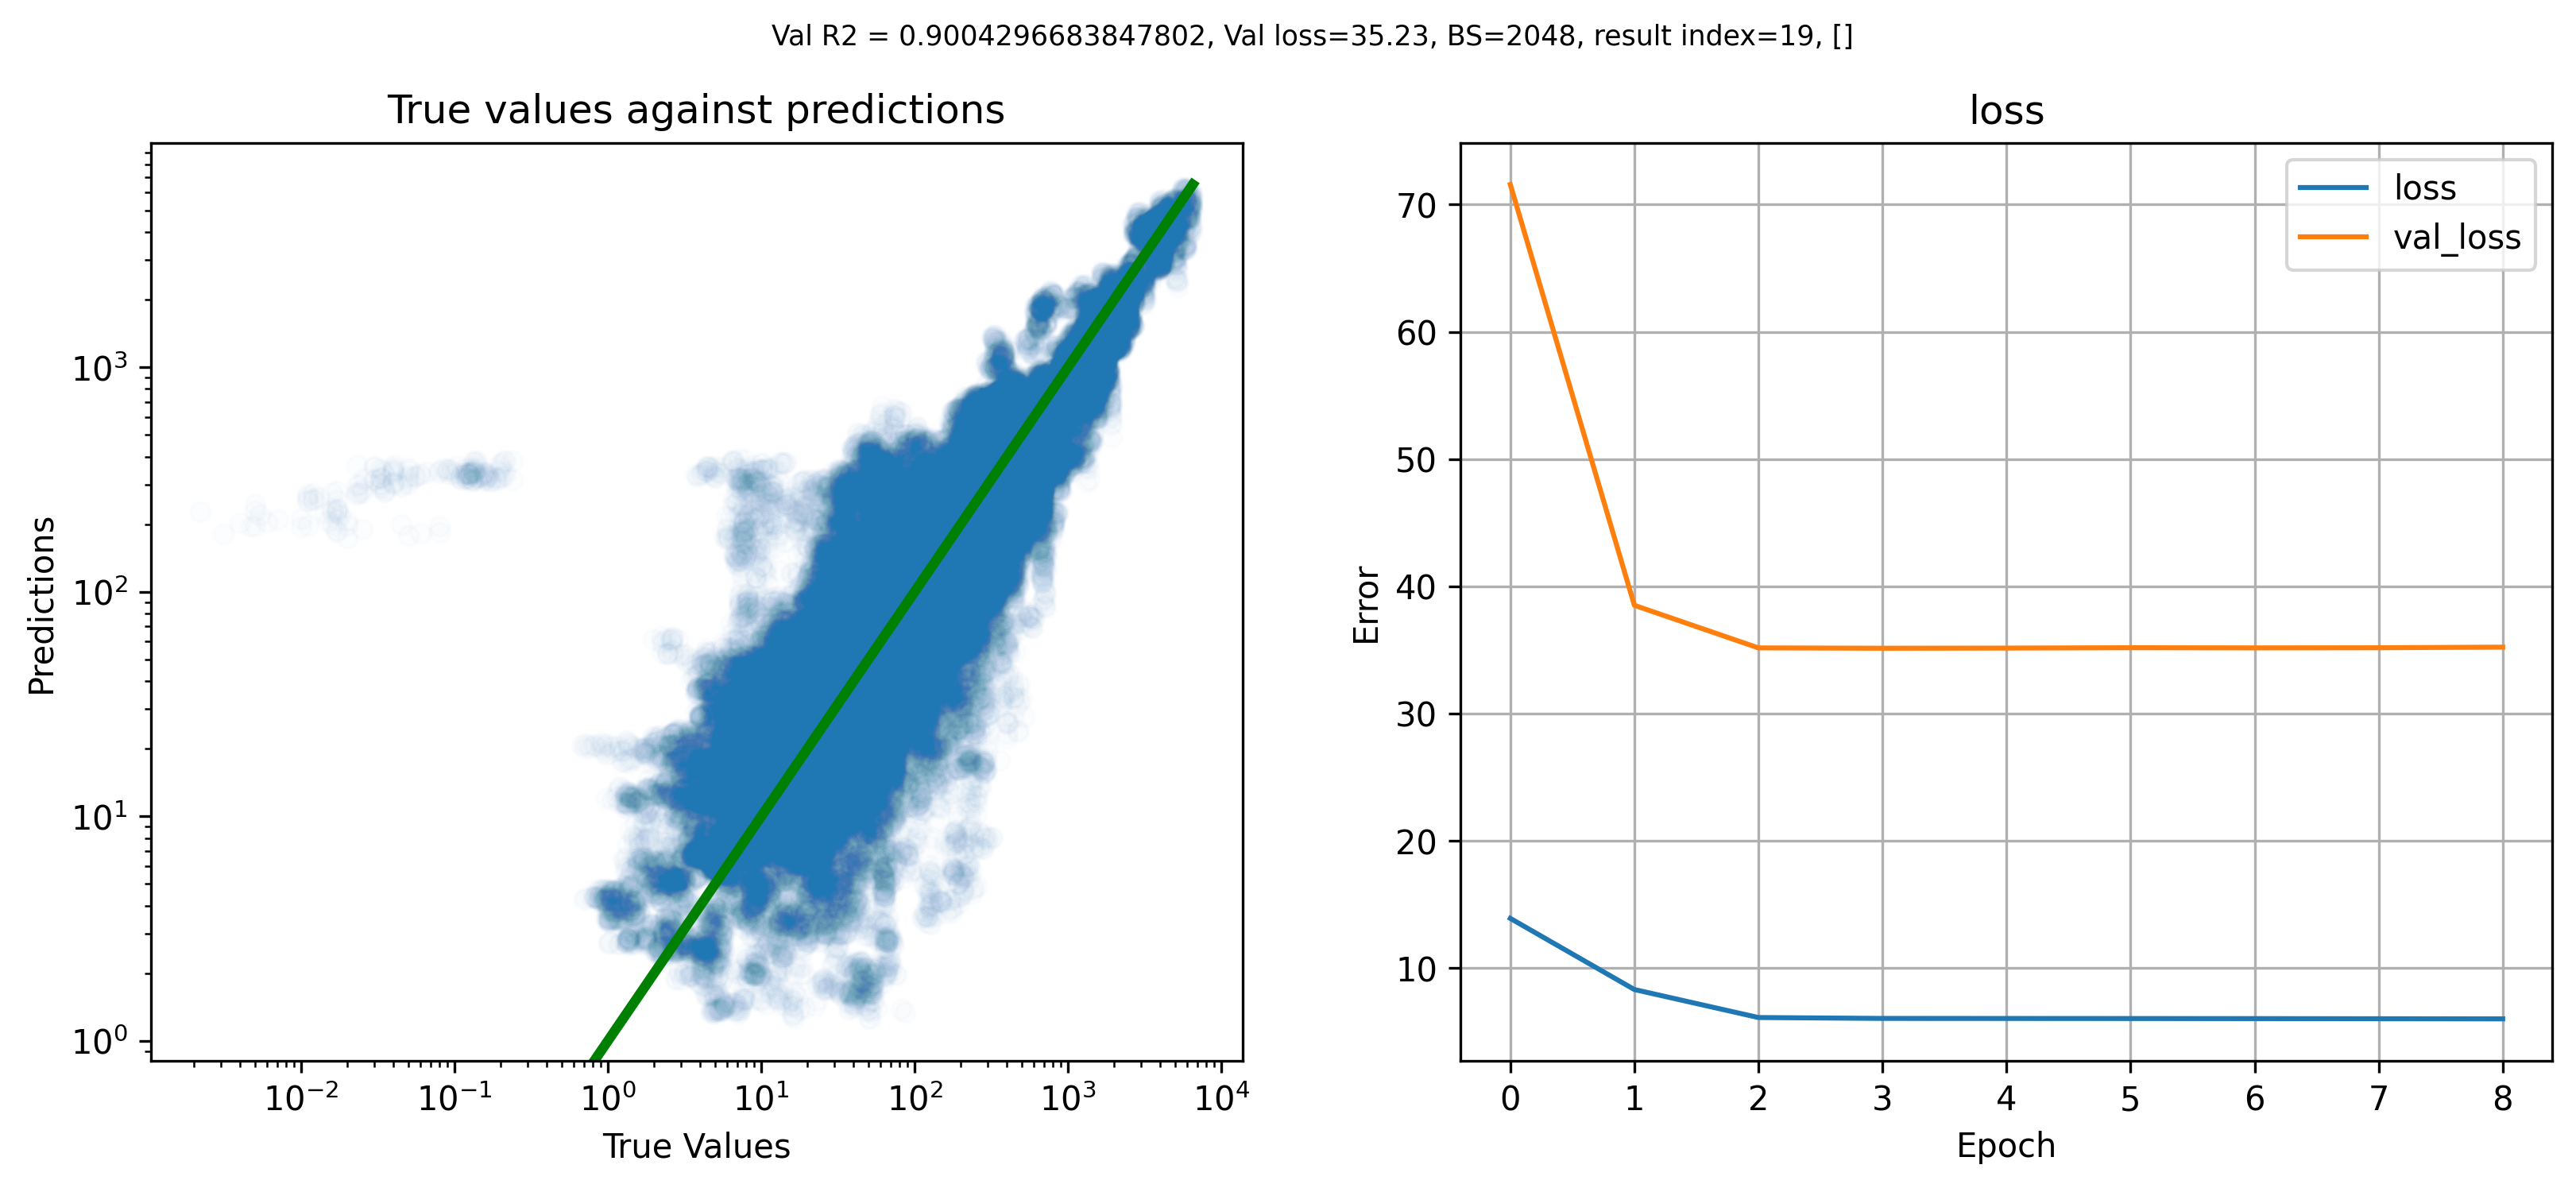

In [14]:
for i in range(len(args_df)):
    args = args_df.loc[i]
    create_model(*args)

# Create plotly graph for model results

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

results = pd.read_csv(model_results_path)

# Identifying the columns that can be used as x-axis variables
x_axis_options = results.columns.drop(['val_loss', 'val_r2'])

# Creating hover text that includes all column information for each point
hover_text_including_val_loss = results.apply(lambda row: '<br>'.join([f"{col}: {row[col]}" for col in results.columns]), axis=1)

# Creating the plot with layout adjustments
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=results[x_axis_options[0]], y=results['val_loss'], mode='markers', name='Loss',
                         hoverinfo="text", text=hover_text_including_val_loss), secondary_y=False)

# Updating the layout with a dropdown menu and y-axis title
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{"x": [results[column]], "hovertext": [hover_text_including_val_loss]}],
                    label=column,
                    method="restyle"
                ) for column in x_axis_options
            ]),
            direction="down",
            showactive=True,
            x=0.85,
            xanchor="left",
            y=1.10,  
            yanchor="top"
        ),
    ],
    title="Interactive Plot",
    yaxis_title="Validation Loss"
)

# Save the figure as an HTML file
html_file_path = f"{root_folder}/{overview_folder}/results.html"
fig.write_html(html_file_path)
print("plot saved")

plot saved
